In [4]:
!pip install kaggle --quiet
!mkdir -p ~/.kaggle

from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv "kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jayaprakashpondy/pancreatic-ct-images
!unzip pancreatic-ct-images.zip -d /content/pancreatic_ct_images


Saving kaggle (1).json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/jayaprakashpondy/pancreatic-ct-images
License(s): CC0-1.0
  0% 0.00/70.1M [00:00<?, ?B/s]
100% 70.1M/70.1M [00:00<00:00, 1.28GB/s]
Archive:  pancreatic-ct-images.zip
  inflating: /content/pancreatic_ct_images/DATASET/test/test/normal/1-001.jpg  
  inflating: /content/pancreatic_ct_images/DATASET/test/test/normal/1-002.jpg  
  inflating: /content/pancreatic_ct_images/DATASET/test/test/normal/1-003.jpg  
  inflating: /content/pancreatic_ct_images/DATASET/test/test/normal/1-004.jpg  
  inflating: /content/pancreatic_ct_images/DATASET/test/test/normal/1-005.jpg  
  inflating: /content/pancreatic_ct_images/DATASET/test/test/normal/1-006.jpg  
  inflating: /content/pancreatic_ct_images/DATASET/test/test/normal/1-007.jpg  
  inflating: /content/pancreatic_ct_images/DATASET/test/test/normal/1-008.jpg  
  inflating: /content/pancreatic_ct_images/DATASET/test/test/normal/1-009.jpg  
  inflating: /content/pancr

In [5]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/pancreatic_ct_images/DATASET'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os

data_dir = "/content/pancreatic_ct_images"
for root, dirs, files in os.walk(data_dir):
    print(root, len(files), "files")


/content/pancreatic_ct_images 0 files
/content/pancreatic_ct_images/DATASET 0 files
/content/pancreatic_ct_images/DATASET/train 0 files
/content/pancreatic_ct_images/DATASET/train/train 0 files
/content/pancreatic_ct_images/DATASET/train/train/normal 421 files
/content/pancreatic_ct_images/DATASET/train/train/pancreatic_tumor 578 files
/content/pancreatic_ct_images/DATASET/test 0 files
/content/pancreatic_ct_images/DATASET/test/test 0 files
/content/pancreatic_ct_images/DATASET/test/test/normal 225 files
/content/pancreatic_ct_images/DATASET/test/test/pancreatic_tumor 187 files


Classes: ['normal', 'pancreatic_tumor']


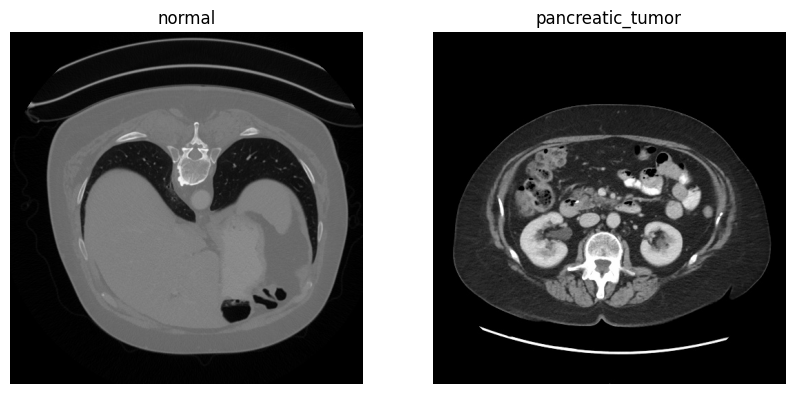

In [7]:
import cv2
import matplotlib.pyplot as plt

train_dir = "/content/pancreatic_ct_images/DATASET/train/train"
test_dir  = "/content/pancreatic_ct_images/DATASET/test/test"

classes = os.listdir(train_dir)
print("Classes:", classes)

plt.figure(figsize=(10,5))
for i, cls in enumerate(classes):
    img_path = os.path.join(train_dir, cls, os.listdir(os.path.join(train_dir, cls))[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(classes), i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()


In [8]:
import numpy as np
from tqdm import tqdm

train_dir = "/content/pancreatic_ct_images/DATASET/train/train"
test_dir  = "/content/pancreatic_ct_images/DATASET/test/test"

classes = os.listdir(train_dir)
print("Classes:", classes)

images, labels = [], []

for cls in classes:
    cls_path = os.path.join(train_dir, cls)
    for img_name in tqdm(os.listdir(cls_path), desc=f"Loading {cls}"):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (224, 224))
        images.append(img)
        labels.append(cls)

images = np.array(images)
labels = np.array(labels)

print("Dataset loaded!")
print("Images shape:", images.shape)
print("Labels:", labels.shape)


Classes: ['normal', 'pancreatic_tumor']


Loading pancreatic_tumor: 100%|██████████| 578/578 [00:02<00:00, 233.86it/s]


Dataset loaded!
Images shape: (999, 224, 224, 3)
Labels: (999,)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# ----- CBAM Module -----
class BasicConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, relu=True):
        super(BasicConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = relu
        if relu:
            self.relu_fn = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.relu:
            x = self.relu_fn(x)
        return x

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=(kernel_size - 1)//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = self.ca(x) * x
        out = self.sa(out) * out
        return out

In [10]:
# ----- Integrate CBAM with ResNet-50 -----
class ResNet50_CBAM(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50_CBAM, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.cbam = CBAM(2048)
        self.model.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.cbam(x)

        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.model.fc(x)
        return x

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50_CBAM(num_classes=2).to(device)
print(" Model initialized on:", device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


 Model initialized on: cuda


Feature Engineering (Data Augmentation + Normalization)

In [11]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Transformations: resizing, augmentation, normalization
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets and loaders
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print("Train samples:", len(train_data))
print("Test samples:", len(test_data))


Train samples: 999
Test samples: 412


Quick Evaluation (Training + Metrics + Visualization)

Epoch [1/3] Train Loss: 0.2899 | Val Loss: 0.2985 | Accuracy: 99.27%
Epoch [2/3] Train Loss: 0.0370 | Val Loss: 0.0920 | Accuracy: 100.00%
Epoch [3/3] Train Loss: 0.0285 | Val Loss: 0.0798 | Accuracy: 100.00%


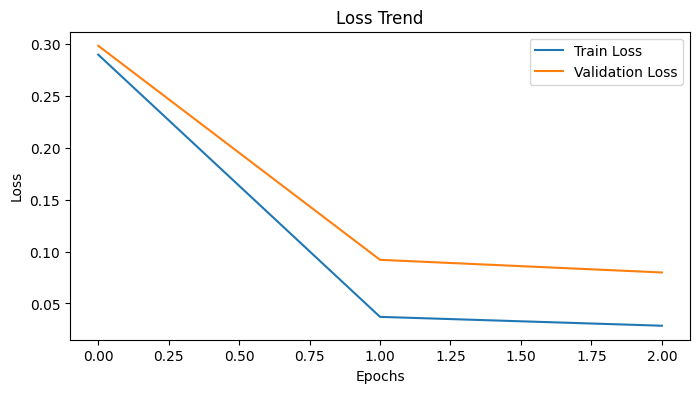

In [12]:
import torch.optim as optim
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses, test_losses, accuracies = [], [], []

EPOCHS = 3  # short run for quick evaluation
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    test_losses.append(val_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_losses[-1]:.4f} | "
          f"Val Loss: {test_losses[-1]:.4f} | "
          f"Accuracy: {accuracy:.2f}%")

# Plot losses
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss Trend')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
